# Clustering Anime via User Scores

Using the same type of data from the collaborative filtering notebook, we again perform cluster analysis to find any hidden patterns amongst the anime based on the users' scores and whether or not they have viewed certain shows.

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Querying User Data

### Querying a Single User

The user "Kosuna" has a very high number of followers, which can give us plenty of data to work with.

In [122]:
user_query = '''
query ($username: String) {
  User(name: $username, sort: [ID]) {
    id
    statistics {
      anime {
        count
        meanScore
        standardDeviation
        episodesWatched
        scores (sort: [ID]) {
          score
          mediaIds
        }
      }
    }
    mediaListOptions {
      scoreFormat
    }
  }
}
'''

variables = {
    'username': "kosuna",
    # 'page': 1,
    # 'perPage': 50
}
url = 'https://graphql.anilist.co'

response = requests.post(url, json={'query': user_query, 'variables': variables})

In [123]:
results = json.loads(response.text)
user_df = pd.json_normalize(results)
user_df

,data.User.id,data.User.statistics.anime.count,data.User.statistics.anime.meanScore,data.User.statistics.anime.standardDeviation,data.User.statistics.anime.episodesWatched,data.User.statistics.anime.scores,data.User.mediaListOptions.scoreFormat
0,126268,422,79.6,10.2,5082,"[{'score': 80, 'mediaIds': [113538, 16762, 378...",POINT_10_DECIMAL


In [124]:
new_user_scores = pd.DataFrame(columns=['userId','animeId','score'])
scores = pd.json_normalize(results['data']['User']['statistics']['anime']['scores'])

for i in range(len(scores)):
  temp = pd.DataFrame({"userId": user_df['data.User.id'][0], "animeId": scores.mediaIds[i],"score":scores.score[i]})
  new_user_scores = pd.concat([temp, new_user_scores],ignore_index=True)

new_user_scores

,userId,animeId,score
0,126268,320,55
1,126268,99531,30
2,126268,21709,40
3,126268,97833,25
4,126268,21519,100
...,...,...,...
159,126268,101165,80
160,126268,8074,80
161,126268,11771,80
162,126268,226,80


In [125]:
new_user_df = pd.pivot(new_user_scores,index="userId",columns="animeId",values="score")
new_user_df

animeId,1,30,32,205,226,267,320,401,405,431,...,112301,112641,113538,114236,114308,115230,116006,124080,127720,129898
userId,,,,,,,,,,,,,,,,,,,,,
126268,90,95,95,95,80,65,55,60,75,80,...,60,90,80,85,75,80,70,80,90,70


### Querying User Followings

We can either query for a user's followers or users they are following. In this case, we query Kosuna's followers and their scores on the anime they've watched. We then concatenate them to make a giant sparse dataframe of scores.

In [126]:
id = int(user_df['data.User.id'][0])
# can change to get user's followers or users they are following
query = '''
query ($userId: Int!, $page: Int, $perPage: Int) {
    Page (page: $page, perPage: $perPage) {
        pageInfo {
            total
            currentPage
            lastPage
            hasNextPage
            perPage
        }
        followers (userId: $userId, sort: [ID]) {
            id
            statistics {
              anime {
                count
                meanScore
                standardDeviation
                episodesWatched
                scores (sort: [ID]) {
                  score
                  mediaIds
                }
              }
            }
            mediaListOptions {
              scoreFormat
            }
            siteUrl
        }
    }
}
'''

variables = {
    'userId': id,
    'page': 1,
    'perPage': 50
}
url = 'https://graphql.anilist.co'

response = requests.post(url, json={'query': query, 'variables': variables})

In [127]:
# change "following" to "followers" or vice versa

results = json.loads(response.text)
following_df = pd.json_normalize(results['data']['Page']['followers'])
len(following_df)

50

In [128]:
# page = 2
# while results['data']['Page']['pageInfo']['hasNextPage']:
for page in range(2,21):
  variables = {
    'userId': id,
    'page': page,
    'perPage': 50
  }
  response = requests.post(url, json={'query': query, 'variables': variables})
  results = json.loads(response.text)
  following_df = pd.concat([following_df, pd.json_normalize(results['data']['Page']['followers'])])
  # page += 1

In [129]:
len(following_df)

1000

In [130]:
# make sure all users are unique and no duplicates

len(following_df.id.unique())

1000

In [131]:
following_df = following_df[following_df['mediaListOptions.scoreFormat'].isin(["POINT_10_DECIMAL","POINT_100"])]
following_df = following_df[following_df['statistics.anime.scores'].apply(lambda x: len(x) > 0)]
following_df = following_df[following_df['statistics.anime.count'] > 0]

In [132]:
# scores = pd.json_normalize(following_df['statistics.anime.scores'].iloc[0])
# user_scores = pd.DataFrame({"userId": following_df['id'].iloc[0], "animeId": scores.mediaIds[0],"score":scores.score[0]})

user_scores = pd.DataFrame(columns=["userId","animeId","score"])

for i in range(len(following_df)):
  scores = pd.json_normalize(following_df['statistics.anime.scores'].iloc[i])
  for j in range(len(scores)):
    temp = pd.DataFrame({"userId": following_df['id'].iloc[i], 
                         "animeId": scores.mediaIds[j],
                         "score":scores.score[j]})
    user_scores = pd.concat([temp, user_scores],ignore_index=True)

# user_scores

In [133]:
user_scores = user_scores.drop_duplicates(subset=['userId','animeId'])
user_scores

,userId,animeId,score
0,155384,1639,10
1,155384,5391,10
2,155384,2476,50
3,155384,99698,50
4,155384,99894,50
...,...,...,...
96003,110,11433,60
96004,110,71,60
96005,110,11785,60
96006,110,21457,60


In [134]:
user_scores_df = pd.pivot(user_scores,index="userId",columns="animeId",values="score")

In [135]:
user_scores_df = pd.concat([user_scores_df,new_user_df])
user_scores_df.head()

animeId,1,5,6,7,15,16,17,18,19,20,...,145059,145560,145813,145897,146066,146441,146566,146934,146984,148104
userId,,,,,,,,,,,,,,,,,,,,,
110,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1492,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1799,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clustering Anime by Popularity/Viewership

In [68]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [69]:
pca = PCA(n_components = 3)

# getting large table of 0s (user has not seen) and 1s (user has seen)
crosstab_data = pd.crosstab(user_scores.animeId, user_scores.userId)
crosstab_data_pca = pca.fit_transform(crosstab_data)
crosstab_data.head()

In [70]:
# final_df_c_pca.shape
crosstab_data_pca.shape

(5631, 3)

In [71]:
cluster_df = pd.DataFrame(crosstab_data_pca)

In [72]:
# elbow method
errors = []
for n in range(1,9):
  kmeans = KMeans(n_clusters=n)
  kmeans.fit(cluster_df)
  errors.append(kmeans.inertia_)

Text(0, 0.5, 'Error')

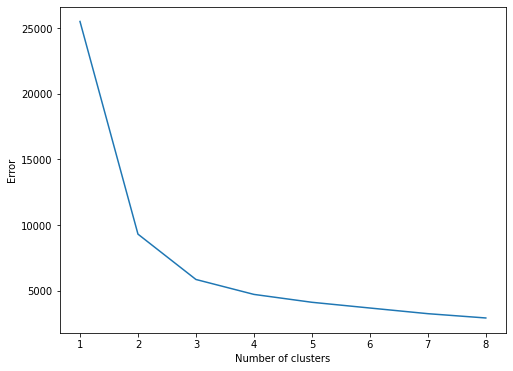

In [73]:
plt.figure(figsize=(8,6))
plt.plot(range(1,9),errors)
plt.xlabel("Number of clusters")
plt.ylabel("Error")

In [74]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(crosstab_data_pca)

KMeans(n_clusters=3)

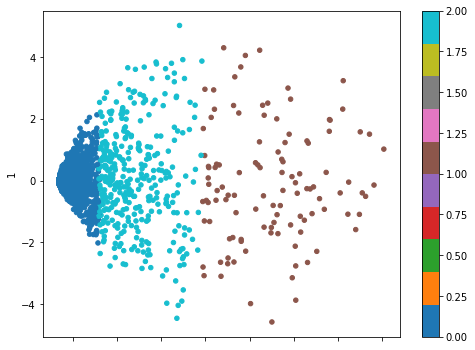

In [75]:
c_preds = kmeans.predict(cluster_df)
pd.DataFrame(crosstab_data_pca).plot.scatter(
    x=0,y=1,c=c_preds,colormap='tab10',figsize=(8,6)
  )

Text(0.5, 0, 'PC 3')

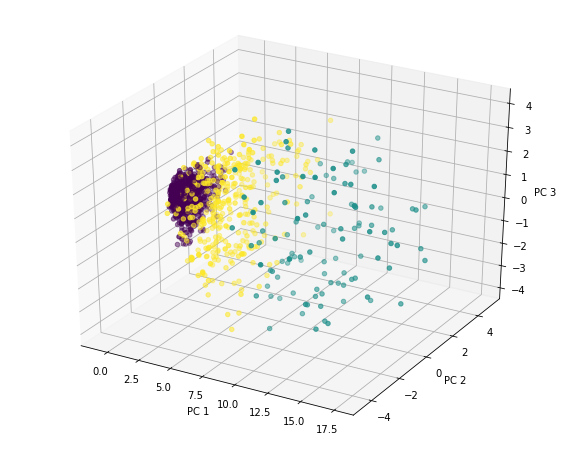

In [76]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(cluster_df[0],cluster_df[1],cluster_df[2],c=c_preds)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

In [77]:
anime_df = pd.read_csv("/content/drive/MyDrive/Anime project/anime-1991-2021_v3.csv")
anime_df.set_index('id',inplace=True)
anime_df = anime_df[anime_df.format != 'OVA']

For each anime per cluster, we calculate the proportion of the users who have consumed it.

In [78]:
crosstab_data['cluster'] = c_preds
merged_df = pd.merge(anime_df,crosstab_data,left_index=True,right_index=True)
# c0 = crosstab_data[crosstab_data.cluster == 0].drop('cluster',axis=1).mean(axis=1).sort_values(ascending=False)[:10]
c0 = merged_df[merged_df.cluster==0].drop('cluster',axis=1).iloc[:,len(anime_df.columns):].mean(axis=1).sort_values(ascending=False)
c0.index = merged_df.loc[c0.index]['title']
c0

title
Evangelion: 2.0 You Can (Not) Advance                      0.097122
Puella Magi Madoka Magica the Movie Part III: Rebellion    0.095324
Evangelion: 3.0 You Can (Not) Redo                         0.093525
Redline                                                    0.091727
The Anthem of the Heart                                    0.091727
                                                             ...   
Monster Rancher (2000)                                     0.001799
Boys Be...                                                 0.001799
Carried by the Wind: Tsukikage Ran                         0.001799
Hand Maid May                                              0.001799
Ristorante Paradiso                                        0.001799
Length: 1746, dtype: float64

In [79]:
# c1 = crosstab_data[crosstab_data.cluster == 1].drop('cluster',axis=1).mean(axis=1).sort_values(ascending=False)[:10]
# c1.index = anime_df.loc[c1.index]['title']
c1 = merged_df[merged_df.cluster==1].drop('cluster',axis=1).iloc[:,len(anime_df.columns):].mean(axis=1).sort_values(ascending=False)
c1.index = merged_df.loc[c1.index]['title']
c1

title
Attack on Titan                     0.750000
Sword Art Online                    0.724820
One-Punch Man                       0.703237
Your Name.                          0.696043
My Hero Academia                    0.690647
                                      ...   
Assassination Classroom 2           0.316547
Food Wars! The Second Plate         0.311151
The Quintessential Quintuplets      0.307554
Seraph of the End: Vampire Reign    0.303957
Rent-a-Girlfriend                   0.300360
Length: 113, dtype: float64

In [80]:
# c2 = crosstab_data[crosstab_data.cluster == 2].drop('cluster',axis=1).mean(axis=1).sort_values(ascending=False)[:10]
# c2.index = anime_df.loc[c2.index]['title']
c2 = merged_df[merged_df.cluster==2].drop('cluster',axis=1).iloc[:,len(anime_df.columns):].mean(axis=1).sort_values(ascending=False)
c2.index = merged_df.loc[c2.index]['title']
c2

title
Terror in Resonance            0.316547
K-ON!                          0.311151
Bleach                         0.303957
HAIKYU!! 3rd Season            0.298561
Log Horizon                    0.296763
                                 ...   
Fuuka                          0.088129
The Way of the Househusband    0.086331
Pop Team Epic                  0.084532
BEASTARS Season 2              0.084532
The Day I Became a God         0.080935
Length: 343, dtype: float64

It seems that our first cluster contains anime that seem to be the least popular/viewed from the data on users I collected. The second cluster contains the most popular mainstream anime, and the third contains shows that are somewhere in between.

## Clustering by Viewer Scores

Now instead of looking at whether or not a user has seen an anime, we look into the users' actual scores to see if there are any clear clusters.

In [121]:
# centering scores to account for generous and harsh scorers. Fill in NAs with 0s as the average

user_scores_df_c = (user_scores_df.T-user_scores_df.T.mean()).fillna(0).T
user_scores_df_c.head()

animeId,1,5,6,7,15,16,17,18,19,20,...,145059,145560,145813,145897,146066,146441,146566,146934,146984,148104
userId,,,,,,,,,,,,,,,,,,,,,
110,32.112403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.112403,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,38.256705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.256705,8.256705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1492,5.668103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.668103,-34.331897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1555,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799,7.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-17.954545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
# final_df_c.drop('cluster',axis=1,inplace=True)

pca_2 = PCA(n_components=3)

scores_data_pca = pca_2.fit_transform(user_scores_df_c.T)
cluster_scores_df = pd.DataFrame(scores_data_pca)

In [111]:
cluster_scores_df

,0,1,2
0,159.986190,-67.950458,58.036338
1,18.232717,-13.052170,7.724259
2,25.437029,-20.030152,14.436384
3,-0.920728,0.430828,-1.147622
4,0.616810,1.799744,5.709008
...,...,...,...
5626,-0.700513,0.905292,-0.196551
5627,0.134731,-0.329877,-0.174015
5628,1.564432,0.743289,-0.614110
5629,-0.533696,-0.036766,0.555419


In [112]:
errors = []
for k in range(1,9):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(cluster_scores_df)
  errors.append(kmeans.inertia_)

Text(0, 0.5, 'Error')

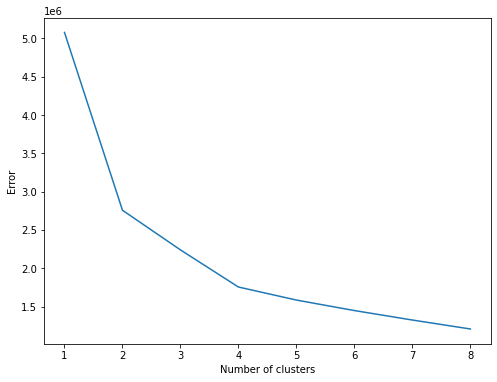

In [113]:
plt.figure(figsize=(8,6))
plt.plot(range(1,9),errors)
plt.xlabel("Number of clusters")
plt.ylabel("Error")

Within-cluster sums of squares are larger than previous analysis, meaning the clusters may not be as clearly defined as before. Nonetheless, per the elbow method we will use *k* = 4 clusters.

In [114]:
kmeans_2 = KMeans(n_clusters=4)
kmeans_2.fit(cluster_scores_df)

KMeans(n_clusters=4)

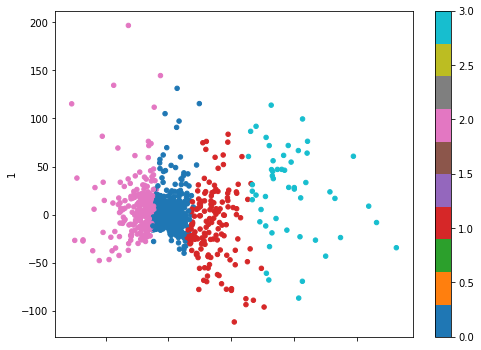

In [115]:
c_preds = kmeans_2.predict(cluster_scores_df)
pd.DataFrame(cluster_scores_df).plot.scatter(
    x=0,y=1,c=c_preds,colormap='tab10',figsize=(8,6)
  )

Text(0.5, 0, 'PC 3')

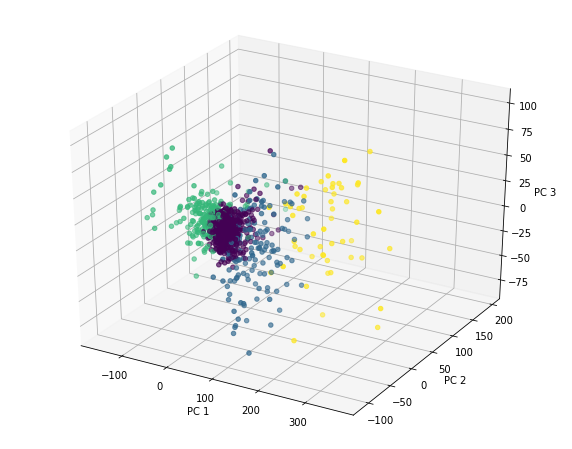

In [116]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(cluster_scores_df[0],cluster_scores_df[1],cluster_scores_df[2],c=c_preds)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

For each anime per cluster, we calculate the grand average number of points users rated greater or less than their average scores.

In [117]:
user_scores_df_c_T = user_scores_df_c.T
user_scores_df_c_T['cluster'] = c_preds
# c0 = final_df_c[final_df_c.cluster == 0].drop('cluster',axis=1).mean(axis=0).sort_values(ascending=False)
merged_df_2 = pd.merge(anime_df,user_scores_df_c_T,left_index=True,right_index=True)

c0 = merged_df_2[merged_df_2.cluster==0].drop('cluster',axis=1).iloc[:,len(anime_df.columns):].mean(axis=1).sort_values(ascending=False)
c0.index = merged_df_2.loc[c0.index]['title']
c0

title
The Rising of the Shield Hero                                                       1.739496
Naruto                                                                              1.691464
Terror in Resonance                                                                 1.411152
GTO: Great Teacher Onizuka                                                          1.396881
That Time I Got Reincarnated as a Slime Season 2 Part 2                             1.360831
                                                                                      ...   
Killing Bites                                                                      -0.915363
Campione!                                                                          -0.928326
Full Dive: This Ultimate Next-Gen Full Dive RPG Is Even Shittier than Real Life!   -1.010478
Girlfriend, Girlfriend                                                             -1.069248
Rokka -Braves of the Six Flowers-                               

This cluster seems to contain a fair mix of popular and niche shows that have mixed scores and reviews from users overall. The average scores range from 1 point lower and 1 point higher than each user's scores.

In [118]:
c1 = merged_df_2[merged_df_2.cluster==1].drop('cluster',axis=1).iloc[:,len(anime_df.columns):].mean(axis=1).sort_values(ascending=False)
c1.index = merged_df_2.loc[c1.index]['title']
c1

title
Neon Genesis Evangelion                4.940400
Clannad: After Story                   4.844706
Puella Magi Madoka Magica              4.602019
Anohana: The Flower We Saw That Day    4.587190
Monogatari Series Second Season        4.515019
                                         ...   
Hanamonogatari                         1.150645
Keep Your Hands Off Eizouken!          1.129698
Daily Lives of High School Boys        1.107290
Sound! Euphonium 2                     1.084535
Soul Eater                             1.060755
Length: 141, dtype: float64

This cluster seems to contain anime that are rather niche or popular within more serious and veteran anime fans. This time, they are overall well-received by that audience. Scores range from 1 point to nearly 5 points higher than each user's average.

In [119]:
c2 = merged_df_2[merged_df_2.cluster==2].drop('cluster',axis=1).iloc[:,len(anime_df.columns):].mean(axis=1).sort_values(ascending=False)
c2.index = merged_df_2.loc[c2.index]['title']
c2

title
FAIRY TAIL (2014)                                          -0.308169
The Irregular at Magic High School                         -0.441275
Akame ga Kill!                                             -0.485331
The Future Diary                                           -0.488097
Sword Art Online: Alicization - War of Underworld Part 2   -0.611046
                                                              ...   
Pupa                                                       -4.526014
In Another World With My Smartphone                        -4.647765
School Days (TV)                                           -4.726068
King's Game                                                -4.765268
Tokyo Ghoul √A                                             -5.255620
Length: 224, dtype: float64

This cluster contains anime that are generally poorly-received by users. All scores in this cluster range up to 5 below user average.

In [120]:
c3 = merged_df_2[merged_df_2.cluster==3].drop('cluster',axis=1).iloc[:,len(anime_df.columns):].mean(axis=1).sort_values(ascending=False)
c3.index = merged_df_2.loc[c3.index]['title']
c3

title
Steins;Gate                                               12.892965
A Silent Voice                                            12.007951
Fullmetal Alchemist: Brotherhood                          11.842574
Your Name.                                                11.530397
Attack on Titan Season 3 Part 2                            9.661247
Hunter x Hunter (2011)                                     9.643687
One-Punch Man                                              8.919571
Demon Slayer: Kimetsu no Yaiba                             8.128224
Made in Abyss                                              8.038464
Mob Psycho 100 II                                          7.965505
Re:ZERO -Starting Life in Another World-                   7.618922
Code Geass: Lelouch of the Rebellion                       7.505346
Attack on Titan                                            7.504604
Your lie in April                                          7.488422
Code Geass: Lelouch of the Rebellion R2   

This cluster contains the most popular anime and ones that are generally well-received by anime fans, whether casual or veteran. 